# Study of impact shifts in 2018 testbeam data
Use Impact_Shifts.txt file from Bruno Alves code  (TestBeamReconstruction)
Terms used :
 - shift : values from Impact_Shifts.txt, one shift for x and for y for each layer
 - diff : difference between rechit position and delay wire chamber (DWC) extrapolated position on HGCAL layer. Depends on the layer, but also on the event. (eventually combined with shift)


In [1]:
import pandas as pd
import uproot
import os
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib widget

In [2]:
os.system("/opt/exp_soft/cms/t3/eos-login -username tcuisset")

#Data 100 GeV
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v16/ntuple_484.root'

# Simulation 100 GeV v3 (sim_proton)
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v3/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

# Simulation 100 GeV v5 (sim_noproton)
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v5/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

# Simulation 100 GeV v7 (with proton)
input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v7_33m/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

for array_i in uproot.iterate(input_file + ":trackimpactntupler/impactPoints", step_size="10MB", library="ak"):
    array_impact = array_i
    break

In [3]:
# Tune memory usage with step_size (real memeory usage is ~300 times step_size)
for array_i in uproot.iterate(input_file + ":rechitntupler/hits", step_size="30MB", library="ak",
    filter_name=["event", 'rechit_detid',
       'rechit_module', 'rechit_layer', 'rechit_chip', 'rechit_channel',
       'rechit_x', 'rechit_y', 'rechit_z', 'rechit_energy']):
    array_hits = array_i
    break

In [4]:
shift_map = { # File taken from Bruno Alves code. Previous provenance unknown. Maps layer-> (shiftX, shiftY)
1 : (-3.52216, 2.72417),
2 : (-3.62642, 2.71253),
3 : (-3.70279, 2.73514),
4 : (-3.68178, 2.69013),
5 : (-3.53902, 2.73582),
6 : (-3.60895, 2.7601),
7 : (-3.77711, 2.70275),
8 : (-3.78309, 2.70013),
9 : (-3.74654, 2.62871),
10 : (-3.79885, 2.64894),
11 : (-3.83036, 2.61498),
12 : (-3.85046, 2.61856),
13 : (-3.80845, 2.6431),
14 : (-3.88973, 2.57074),
15 : (-3.83787, 2.64904),
16 : (-3.93072, 2.62127),
17 : (-3.84896, 2.591),
18 : (-3.93918, 2.60614),
19 : (-3.918, 2.53426),
20 : (-3.96107, 2.5747),
21 : (-3.99221, 2.60619),
22 : (-4.03038, 2.62723),
23 : (-3.97634, 2.5293),
24 : (-3.98103, 2.59362),
25 : (-3.99045, 2.58746),
26 : (-4.02747, 2.57666),
27 : (-4.00032, 2.48522),
28 : (-3.95834, 2.49272),
}
#Put it in a dataframe
df_shifts = pd.DataFrame.from_dict(shift_map, orient="index", columns=["shiftX", "shiftY"]).rename_axis("layer")

#Map layer to z position
layer_to_z = {1: 13.8774995803833,
  2: 14.767499923706055,
  3: 16.782499313354492,
  4: 17.672500610351562,
  5: 19.6875,
  6: 20.577499389648438,
  7: 22.6924991607666,
  8: 23.582500457763672,
  9: 25.697500228881836,
  10: 26.587499618530273,
  11: 28.702499389648438,
  12: 29.592500686645508,
  13: 31.50749969482422,
  14: 32.397499084472656,
  15: 34.3125,
  16: 35.20249938964844,
  17: 37.11750030517578,
  18: 38.00749969482422,
  19: 39.92250061035156,
  20: 40.8125,
  21: 42.907501220703125,
  22: 44.037498474121094,
  23: 46.412498474121094,
  24: 47.54249954223633,
  25: 49.68199920654297,
  26: 50.6879997253418,
  27: 52.881500244140625,
  28: 53.903499603271484}


In [5]:
df_hits = ak.to_dataframe(array_hits, levelname=lambda i : {0 : "event_minus_one", 1:"rechit_id"}[i]).reset_index(level=1).reset_index(level=0, drop=True).set_index("event")
df_impact = ak.to_dataframe(array_impact, levelname=lambda i: {0 : "event_minus_one"}[i]).reset_index(drop=True).set_index("event")

In [6]:
df_full = pd.merge(df_hits, df_impact, on="event").set_index("rechit_id", append=True)

In [7]:
#Selections taken from Matteo Bonanomi : https://github.com/bonanomi/HGCALStandaloneAnalysis/blob/master/setup/reader.py
hit_sel = (
    (df_full.rechit_energy > 0.5) # Half-a-MIP cut
    # Kill faulty chips
    & (df_full.ntracks == 1) & (df_full.dwcReferenceType == 13)
    & ~((df_full.rechit_chip == 3) & (df_full.rechit_channel == 22)) & ~((df_full.rechit_module == 78) & (df_full.rechit_chip == 0)) & (((df_full.rechit_layer != 37) & (df_full.rechit_layer != 36)))
    # Select only events with good delay wire chamber information
    & (df_full.ntracks == 1) & (df_full.dwcReferenceType == 13)
)
hit_sel.value_counts()

True     3337996
False     158828
dtype: int64

In [8]:
df_selected = df_full[hit_sel].copy()

## Compute barycenter of hits x and y using rechit_energy

In [9]:
# Compute x*energy
df_selected["rechit_EtX"] = df_selected["rechit_x"] * df_selected["rechit_energy"] # Energy times x position
df_selected["rechit_EtY"] = df_selected["rechit_y"] * df_selected["rechit_energy"]

#Use the shift map to shift positions before taking barycenter
df_selected_with_shifts = pd.merge(df_selected.reset_index(), df_shifts, left_on="rechit_layer", right_on="layer")
df_selected_with_shifts["rechit_EtX_shifted"] = (df_selected_with_shifts["rechit_x"] - df_selected_with_shifts["shiftX"]) * df_selected_with_shifts["rechit_energy"] # Energy times x position
df_selected_with_shifts["rechit_EtY_shifted"] = (df_selected_with_shifts["rechit_y"] - df_selected_with_shifts["shiftY"]) * df_selected_with_shifts["rechit_energy"]
df_selected_with_shifts


,event,rechit_id,rechit_detid,rechit_module,rechit_layer,rechit_chip,rechit_channel,rechit_x,rechit_y,rechit_z,...,m_x,m_y,b_x,b_y,rechit_EtX,rechit_EtY,shiftX,shiftY,rechit_EtX_shifted,rechit_EtY_shifted
0,1,1,16777342,78,1,2,40,-0.971764,1.683144,13.8775,...,-0.010695,-0.005780,-1.814569,1.485488,-3.256837,5.641006,-3.52216,2.72417,8.547577,-3.488967
1,1,2,16777405,78,1,1,40,-1.943527,2.244192,13.8775,...,-0.010695,-0.005780,-1.814569,1.485488,-8.292636,9.575511,-3.52216,2.72417,6.735706,-2.047969
2,1,3,16777406,78,1,1,38,-1.943527,1.122096,13.8775,...,-0.010695,-0.005780,-1.814569,1.485488,-9.310634,5.375496,-3.52216,2.72417,7.562575,-7.674873
3,2,0,16777342,78,1,2,40,-0.971764,1.683144,13.8775,...,-0.010650,-0.005773,-2.200416,1.115357,-4.447693,7.703630,-3.52216,2.72417,11.672982,-4.764702
4,2,1,16777343,78,1,1,36,-0.971764,0.561048,13.8775,...,-0.010650,-0.005773,-2.200416,1.115357,-10.556390,6.094734,-3.52216,2.72417,27.705274,-23.498265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231670,5463,635,469762301,144,28,3,42,-2.915291,1.683144,53.9035,...,-0.010681,-0.005824,-2.094492,1.397293,-2.303955,1.330189,-3.95834,2.49272,0.824322,-0.639808
3231671,5465,662,469762303,144,28,3,54,-2.915291,-0.561048,53.9035,...,-0.010664,-0.005825,-1.683305,1.084299,-3.912697,-0.752999,-3.95834,2.49272,1.399907,-4.098552
3231672,5465,663,469762366,144,28,3,56,-3.887054,0.000000,53.9035,...,-0.010664,-0.005825,-1.683305,1.084299,-3.108815,0.000000,-3.95834,2.49272,0.057013,-1.993645
3231673,5465,664,469762367,144,28,3,16,-3.887054,-1.122096,53.9035,...,-0.010664,-0.005825,-1.683305,1.084299,-2.016330,-0.582064,-3.95834,2.49272,0.036978,-1.875112


In [10]:
# Make barycenter per event and layer
barycenter_event_df = df_selected_with_shifts.groupby(["event", "rechit_layer"]).agg(
    rechit_EtX_sum=pd.NamedAgg(column="rechit_EtX", aggfunc="sum"), # Sum energy*x
    rechit_EtY_sum=pd.NamedAgg(column="rechit_EtY", aggfunc="sum"),
    rechit_EtX_shifted_sum=pd.NamedAgg(column="rechit_EtX_shifted", aggfunc="sum"), # Same but for shifted positions
    rechit_EtY_shifted_sum=pd.NamedAgg(column="rechit_EtY_shifted", aggfunc="sum"),
    rechit_E_sum=pd.NamedAgg(column="rechit_energy", aggfunc="sum"), # Sum energy (for normalization)
).rename_axis(index={"rechit_layer":"layer"})
# Compute the actual barycenters
barycenter_event_df["layer_x_barycenter"] = barycenter_event_df.rechit_EtX_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df["layer_y_barycenter"] = barycenter_event_df.rechit_EtY_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df["layer_x_shifted_barycenter"] = barycenter_event_df.rechit_EtX_shifted_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df["layer_y_shifted_barycenter"] = barycenter_event_df.rechit_EtY_shifted_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df

rechit_EtX_sum  rechit_EtY_sum  rechit_EtX_shifted_sum  \
event layer                                                           
1     1          -20.860107       20.592014               22.845858   
      2         -128.674881       76.106171              112.053631   
      3         -331.515808      262.113373              366.511537   
      4         -516.552795      377.451569              634.605754   
      5        -1071.775635      820.998291              885.155423   
...                     ...             ...                     ...   
5470  22         -84.956581       25.828915               12.780878   
      23        -166.549332      -38.733627               29.811439   
      24        -115.212723        5.088491               -6.357551   
      25        -126.813339       10.156052               45.833647   
      27          30.759090       24.862276               56.083400   

             rechit_EtY_shifted_sum  rechit_E_sum  layer_x_barycenter  \
event layer                                                             
1     1                  -13.211809     12.408853           -1.681067   
      2                 -103.956631     66.381859           -1.938404   
      3                 -253.498518    188.513885           -1.758575   
      4                 -463.654148    312.663605           -1.652104   
      5                 -691.796542    552.958496           -1.938257   
...                             ...           ...                 ...   
5470  22                 -37.881895     24.250183           -3.503338   
      23                -163.636259     49.382290           -3.372653   
      24                 -65.830078     27.343470           -4.213537   
      25                -101.790512     43.265041           -2.931081   
      27                   9.129416      6.330571            4.858818   

             layer_y_barycenter  layer_x_shifted_barycenter  \
event layer                                                   
1     1                1.659462                    1.841094   
      2                1.146490                    1.688016   
      3                1.390419                    1.944215   
      4                1.207213                    2.029676   
      5                1.484738                    1.600763   
...                         ...                         ...   
5470  22               1.065102                    0.527043   
      23              -0.784363                    0.603687   
      24               0.186095                   -0.232507   
      25               0.234740                    1.059369   
      27               3.927336                    8.859138   

             layer_y_shifted_barycenter  
event layer                              
1     1                       -1.064708  
      2                       -1.566040  
      3                       -1.344721  
      4                       -1.482917  
      5                       -1.251082  
...                                 ...  
5470  22                      -1.562128  
      23                      -3.313663  
      24                      -2.407525  
      25                      -2.352720  
      27                       1.442116  

[149500 rows x 9 columns]

In [11]:
pd.set_option('display.min_rows', 100)
df_impact

,run,ntracks,impactX_HGCal_layer_1,impactY_HGCal_layer_1,impactX_HGCal_layer_2,impactY_HGCal_layer_2,impactX_HGCal_layer_3,impactY_HGCal_layer_3,impactX_HGCal_layer_4,impactY_HGCal_layer_4,...,impactY_HGCal_layer_93,impactX_HGCal_layer_94,impactY_HGCal_layer_94,trackChi2_X,trackChi2_Y,dwcReferenceType,m_x,m_y,b_x,b_y
event,,,,,,,,,,,,,,,,,,,,,
1,0,1,-1.962988,1.405270,-1.972507,1.400126,-1.994057,1.388478,-2.003575,1.383334,...,-999.0,-999.0,-999.0,0.011428,1.275474e-01,13,-0.010695,-0.005780,-1.814569,1.485488
2,0,1,-2.348212,1.035237,-2.357691,1.030099,-2.379151,1.018465,-2.388629,1.013327,...,-999.0,-999.0,-999.0,6.025321,1.912737e-01,13,-0.010650,-0.005773,-2.200416,1.115357
3,0,1,-1.813584,1.594926,-1.823061,1.589752,-1.844515,1.578038,-1.853992,1.572864,...,-999.0,-999.0,-999.0,0.135932,5.773767e-01,13,-0.010648,-0.005814,-1.665822,1.675603
4,0,1,-2.245314,1.757290,-2.254786,1.752127,-2.276231,1.740438,-2.285703,1.735275,...,-999.0,-999.0,-999.0,0.846254,8.105902e-02,13,-0.010643,-0.005801,-2.097621,1.837794
5,0,1,-1.602198,2.194934,-1.611668,2.189797,-1.633108,2.178166,-1.642578,2.173029,...,-999.0,-999.0,-999.0,1.061226,2.827026e+00,13,-0.010640,-0.005772,-1.454538,2.275036
6,0,1,-1.591003,2.197643,-1.600480,2.192504,-1.621935,2.180870,-1.631411,2.175732,...,-999.0,-999.0,-999.0,0.022361,3.841878e+00,13,-0.010648,-0.005774,-1.443240,2.277767
7,0,1,-2.062279,1.887614,-2.071738,1.882465,-2.093155,1.870805,-2.102614,1.865655,...,-999.0,-999.0,-999.0,1.210072,3.700681e-03,13,-0.010629,-0.005786,-1.914781,1.967916
8,0,1,-1.333042,1.668280,-1.342545,1.663147,-1.364059,1.651525,-1.373561,1.646392,...,-999.0,-999.0,-999.0,1.812813,2.098925e+00,13,-0.010677,-0.005768,-1.184872,1.748323
9,0,1,-1.842097,1.226504,-1.851566,1.221317,-1.873006,1.209573,-1.882475,1.204386,...,-999.0,-999.0,-999.0,0.173833,1.088484e+00,13,-0.010640,-0.005828,-1.694440,1.307384


In [12]:
def shiftCol(df:pd.DataFrame, colName_head:str, x_or_y):
    """ Apply a shift (with minus sign) on all columns of the name colName_headi where i is all layers
    x_or_y : 0 for x, 1 for y"""
    for i in range(1, 29):
        # Note the minus one
        df["shifted_"+colName_head+str(i)] = - 1 * df[colName_head+str(i)] + shift_map[i][x_or_y]

def melt(df, colName_head, outColName):
    """ Transform all impactX_HGCal_layer_i columns into rows"""
    return (df[[colName_head+str(i) for i in range(1, 29)]]
        .reset_index()
        .melt(id_vars="event", var_name="layer", value_name=outColName)
        .set_index(["event", "layer"])
        .rename(index={colName_head+str(i) : i for i in range(1, 29)})
        .sort_index()
    )

In [13]:
df_impact_layer = melt(df_impact, "impactX_HGCal_layer_", "impactX")
df_impact_layer["impactY"] = melt(df_impact, "impactY_HGCal_layer_", "impactY")
shiftCol(df_impact, "impactX_HGCal_layer_", 0)
shiftCol(df_impact, "impactY_HGCal_layer_", 1)
df_impact_layer["impactX_shifted"] = melt(df_impact, "shifted_impactX_HGCal_layer_", "impactX_shifted")
df_impact_layer["impactY_shifted"] = melt(df_impact, "shifted_impactY_HGCal_layer_", "impactY_shifted")
df_impact_layer

impactX   impactY  impactX_shifted  impactY_shifted
event layer                                                      
1     1     -1.962988  1.405270        -1.559172         1.318900
      2     -1.972507  1.400126        -1.653913         1.312404
      3     -1.994057  1.388478        -1.708733         1.346662
      4     -2.003575  1.383334        -1.678205         1.306796
      5     -2.025126  1.371686        -1.513894         1.364134
      6     -2.034644  1.366541        -1.574306         1.393559
      7     -2.057264  1.354316        -1.719846         1.348434
      8     -2.066783  1.349171        -1.716307         1.350959
      9     -2.089402  1.336946        -1.657138         1.291764
      10    -2.098921  1.331801        -1.699929         1.317139
      11    -2.121541  1.319575        -1.708819         1.295405
      12    -2.131059  1.314431        -1.719401         1.304129
      13    -2.151540  1.303361        -1.656910         1.339739
      14    -2.161059  1.298217        -1.728671         1.272523
      15    -2.181540  1.287147        -1.656330         1.361893
      16    -2.191058  1.282003        -1.739662         1.339267
      17    -2.211539  1.270933        -1.637421         1.320067
      18    -2.221058  1.265788        -1.718122         1.340351
      19    -2.241538  1.254719        -1.676462         1.279541
      20    -2.251057  1.249574        -1.710013         1.325126
      21    -2.273463  1.237464        -1.718747         1.368726
      22    -2.285548  1.230932        -1.744832         1.396297
      23    -2.310949  1.217204        -1.665391         1.312096
      24    -2.323034  1.210672        -1.657996         1.382948
      25    -2.345916  1.198305        -1.644534         1.389155
      26    -2.356675  1.192490        -1.670795         1.384170
      27    -2.380135  1.179810        -1.620185         1.305410
      28    -2.391065  1.173903        -1.567275         1.318817
2     1     -2.348212  1.035237        -1.173948         1.688933
      2     -2.357691  1.030099        -1.268729         1.682431
...               ...       ...              ...              ...
19900 27    -3.041461  2.029896        -0.958859         0.455324
      28    -3.052334  2.023978        -0.906006         0.468742
19901 1     -2.753789  2.186435        -0.768371         0.537735
      2     -2.763324  2.181276        -0.863096         0.531254
      3     -2.784911  2.169594        -0.917879         0.565547
      4     -2.794446  2.164434        -0.887334         0.525696
      5     -2.816033  2.152752        -0.722987         0.583068
      6     -2.825568  2.147592        -0.783382         0.612508
      7     -2.848227  2.135330        -0.928884         0.567420
      8     -2.857761  2.130170        -0.925329         0.569960
      9     -2.880420  2.117909        -0.866120         0.510801
      10    -2.889955  2.112749        -0.908895         0.536191
      11    -2.912614  2.100487        -0.917746         0.514493
      12    -2.922148  2.095327        -0.928312         0.523233
      13    -2.942664  2.084225        -0.865786         0.558875
      14    -2.952199  2.079065        -0.937531         0.491675
      15    -2.972715  2.067963        -0.865155         0.581077
      16    -2.982250  2.062803        -0.948470         0.558467
      17    -3.002766  2.051701        -0.846194         0.539299
      18    -3.012301  2.046541        -0.926879         0.559599
      19    -3.032817  2.035439        -0.885183         0.498821
      20    -3.042352  2.030279        -0.918718         0.544421
      21    -3.064796  2.018133        -0.927413         0.588057
      22    -3.076902  2.011582        -0.953477         0.615648
      23    -3.102347  1.997813        -0.873993         0.531487
      24    -3.114453  1.991262        -0.866577         0.602358
      25    -3.137374  1.978858        -0.853076         0.608602
      26    -3.148151  1.973026        -0.879319      

In [14]:
barycenter_impact_df = pd.merge(barycenter_event_df, df_impact_layer, left_index=True, right_index=True)
# Make barycenter of hits then substract impact
barycenter_impact_df["bary_impact_diff_x"] = barycenter_impact_df["layer_x_barycenter"] - barycenter_impact_df["impactX"]
barycenter_impact_df["bary_impact_diff_y"] = barycenter_impact_df["layer_y_barycenter"] - barycenter_impact_df["impactY"]

# Make barycenter of hits then substract shifted impact (cross-check for bary_impact_diff_x_shiftedBefore_plus, is the same)
# Here we use a minus but because there is another minus that was already applied when impactX_shifted was constructed
barycenter_impact_df["bary_impact_diff_x_shiftedAfter"] = barycenter_impact_df["layer_x_barycenter"] - barycenter_impact_df["impactX_shifted"]
barycenter_impact_df["bary_impact_diff_y_shiftedAfter"] = barycenter_impact_df["layer_y_barycenter"] - barycenter_impact_df["impactY_shifted"]

# Shift positions of hits then barycenter then substract impact
## _plus : *add* impactX : seems to work but very weird
barycenter_impact_df["bary_impact_diff_x_shiftedBefore_plus"] = barycenter_impact_df["layer_x_shifted_barycenter"] + barycenter_impact_df["impactX"]
barycenter_impact_df["bary_impact_diff_y_shiftedBefore_plus"] = barycenter_impact_df["layer_y_shifted_barycenter"] + barycenter_impact_df["impactY"]

## _plus : *substract* impactX : what would seem the correct way to do it but does not get the correct results
barycenter_impact_df["bary_impact_diff_x_shiftedBefore_minus"] = barycenter_impact_df["layer_x_shifted_barycenter"] - barycenter_impact_df["impactX"]
barycenter_impact_df["bary_impact_diff_y_shiftedBefore_minus"] = barycenter_impact_df["layer_y_shifted_barycenter"] - barycenter_impact_df["impactY"]


barycenter_impact_df

rechit_EtX_sum  rechit_EtY_sum  rechit_EtX_shifted_sum  \
event layer                                                           
1     1          -20.860107       20.592014               22.845858   
      2         -128.674881       76.106171              112.053631   
      3         -331.515808      262.113373              366.511537   
      4         -516.552795      377.451569              634.605754   
      5        -1071.775635      820.998291              885.155423   
      6        -1518.928833     1170.295044             1278.271402   
      7        -1927.523926     1476.576904             1860.694606   
      8        -1690.400513     1174.071167             1663.572102   
      9        -2084.893311     1316.396362             2024.865953   
      10       -1768.662109     1055.750488             1479.605258   
      11       -1657.962769     1352.082031             1768.952010   
      12       -1393.958374      926.509460             1433.968408   
      13       -1273.915771     1101.555420             1416.093219   
      14        -865.779297      519.482971             1054.985882   
      15        -617.071777      473.624115              814.099921   
      16        -491.967804      366.646027              689.248963   
      17        -608.600525      284.584534              454.408945   
      18        -235.753296      147.010925              251.542957   
      19        -287.727661      222.432724              311.875304   
      20        -240.772186      141.738449              216.210866   
      21         -88.287064      115.578217              160.801657   
      22         -80.430008       29.849958              100.400734   
      23         -73.589317       52.676682              121.549158   
      24         -43.081837       30.245319                6.901411   
      25         -37.792671       12.132757                0.494352   
      26         -10.774463      -10.579700               31.415681   
      27           8.371273       20.900291               42.460665   
      28          -2.966675        2.854684                1.061434   
2     1         -226.872452      115.286827              239.239367   
      2         -449.369629      193.079239              409.534972   
...                     ...             ...                     ...   
5469  24          -9.097195       12.923947               24.907794   
      25         -17.641745       13.725846                5.911675   
      26         -11.172472        5.164468                1.185199   
      27          11.026337        0.476687               25.224563   
5470  1         -117.975327       39.073421               38.726284   
      2         -494.155151      153.616043              161.225330   
      3         -791.218567      270.650757              324.405851   
      4        -1523.220825      398.919464              548.775544   
      5        -2284.527832      633.244751              724.160073   
      6        -2621.106445      654.985107              678.354087   
      7        -3295.869873      856.462646             1335.302825   
      8        -2855.250488      532.672180             1081.289480   
      9        -2455.733887      702.495483             1063.276613   
      10       -2087.806152      558.418823             1090.869590   
      11       -2144.291992      452.311401             1030.976167   
      12       -1579.682007      545.967712              963.649313   
      13       -1306.696899      158.291870              655.763032   
      14        -941.058350      212.001114              477.973024   
      15        -862.153503       37.404758              354.924427   
      16        -285.729797       50.572819              165.245171   
      17        -461.688293       93.735123              287.011798   
      18        -388.914398       71.625900              144.975185   
      19        -213.635010       52.993767              144.121059   
      20         -49.111340       24.

In [15]:
def makePlots(plot_df, varName):
    fig, axes = plt.subplots(6, 5, figsize=(64/3, 48/3), dpi=300, sharex=True, sharey=False)
    flat_axes= np.array(axes).flatten()
    for layer in range(1, 28):
        ax = flat_axes[layer-1]
        df_cur_layer = plot_df[plot_df.layer == layer]
        df_cur_layer[varName].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="unshifted")
        df_cur_layer[varName+"_shiftedBefore_plus"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted before bary (+impact)")
        df_cur_layer[varName+"_shiftedBefore_minus"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted before bary (-impact)")
        
        # Cross-check : should be exactly the same as varName+"_shiftedBefore_plus"
        #df_cur_layer[varName+"_shiftedAfter"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted after bary (+impact)")
        ax.set_title("Layer=" + str(layer))
        ax.set_xlabel(varName+" (cm)")
    handles, labels = flat_axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='right')

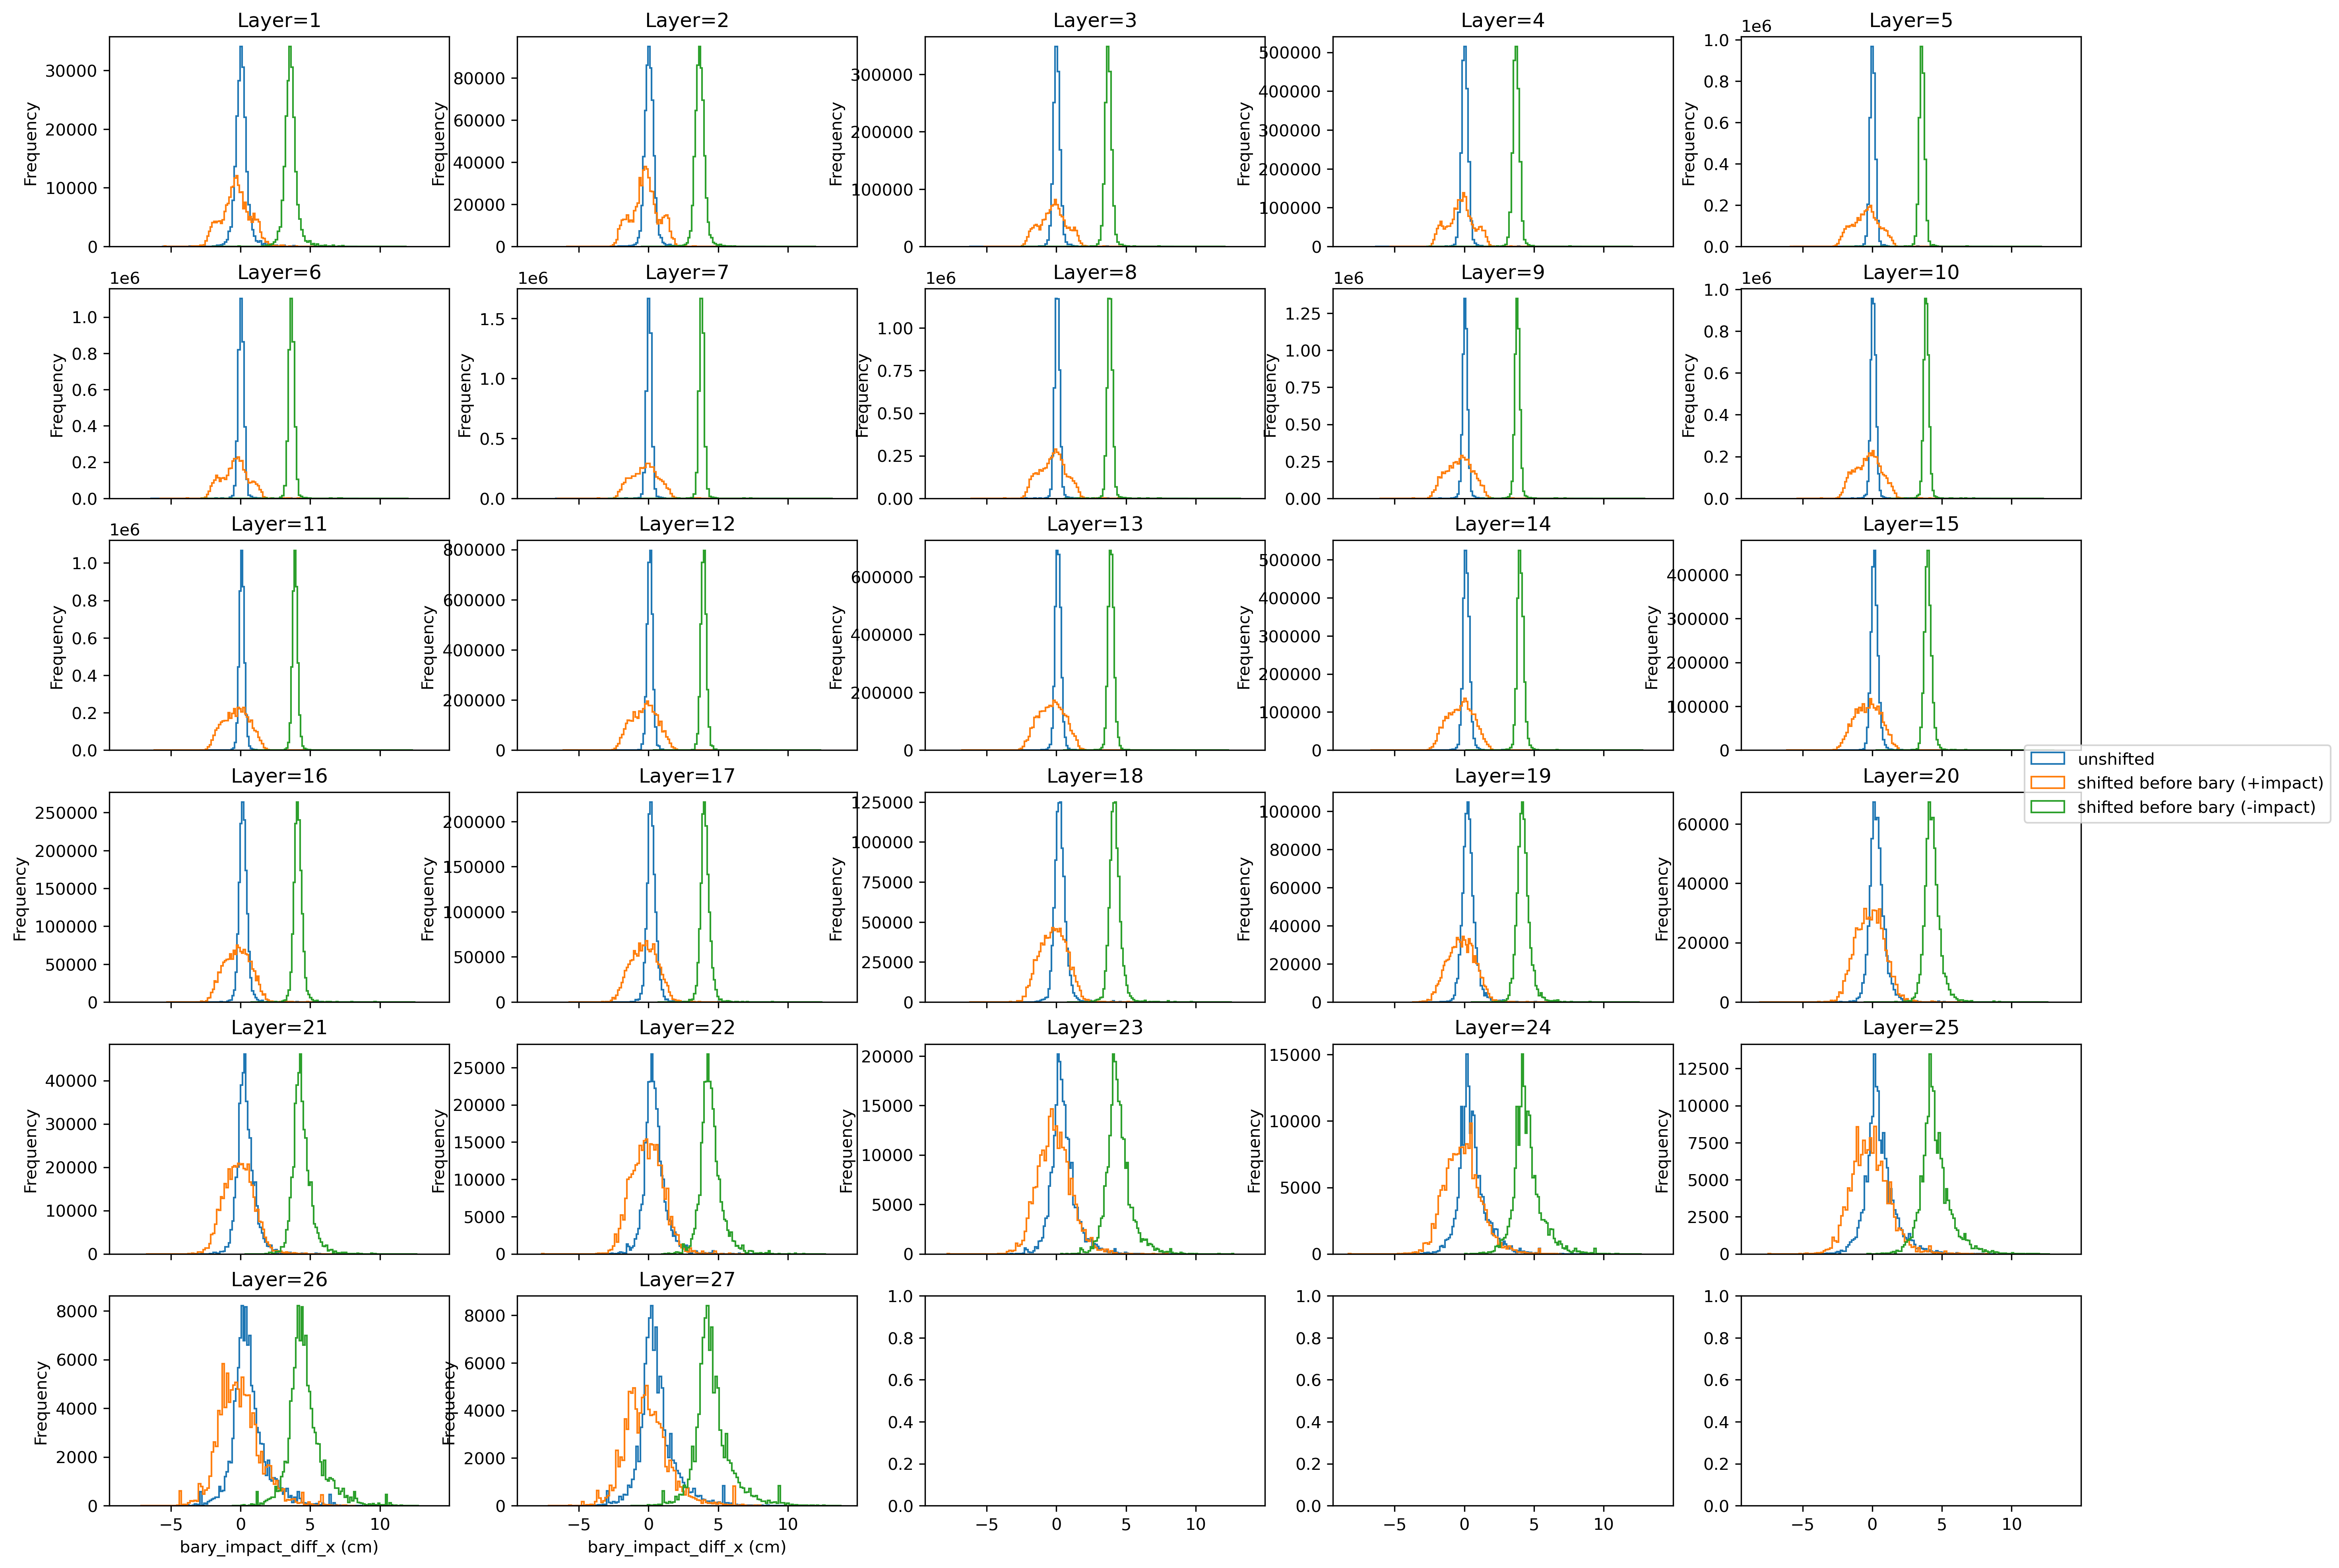

In [16]:
plot_df = barycenter_impact_df.reset_index(level="layer")
#plot_df = plot_df[plot_df.rechit_E_sum > 100]
makePlots(plot_df, "bary_impact_diff_x")

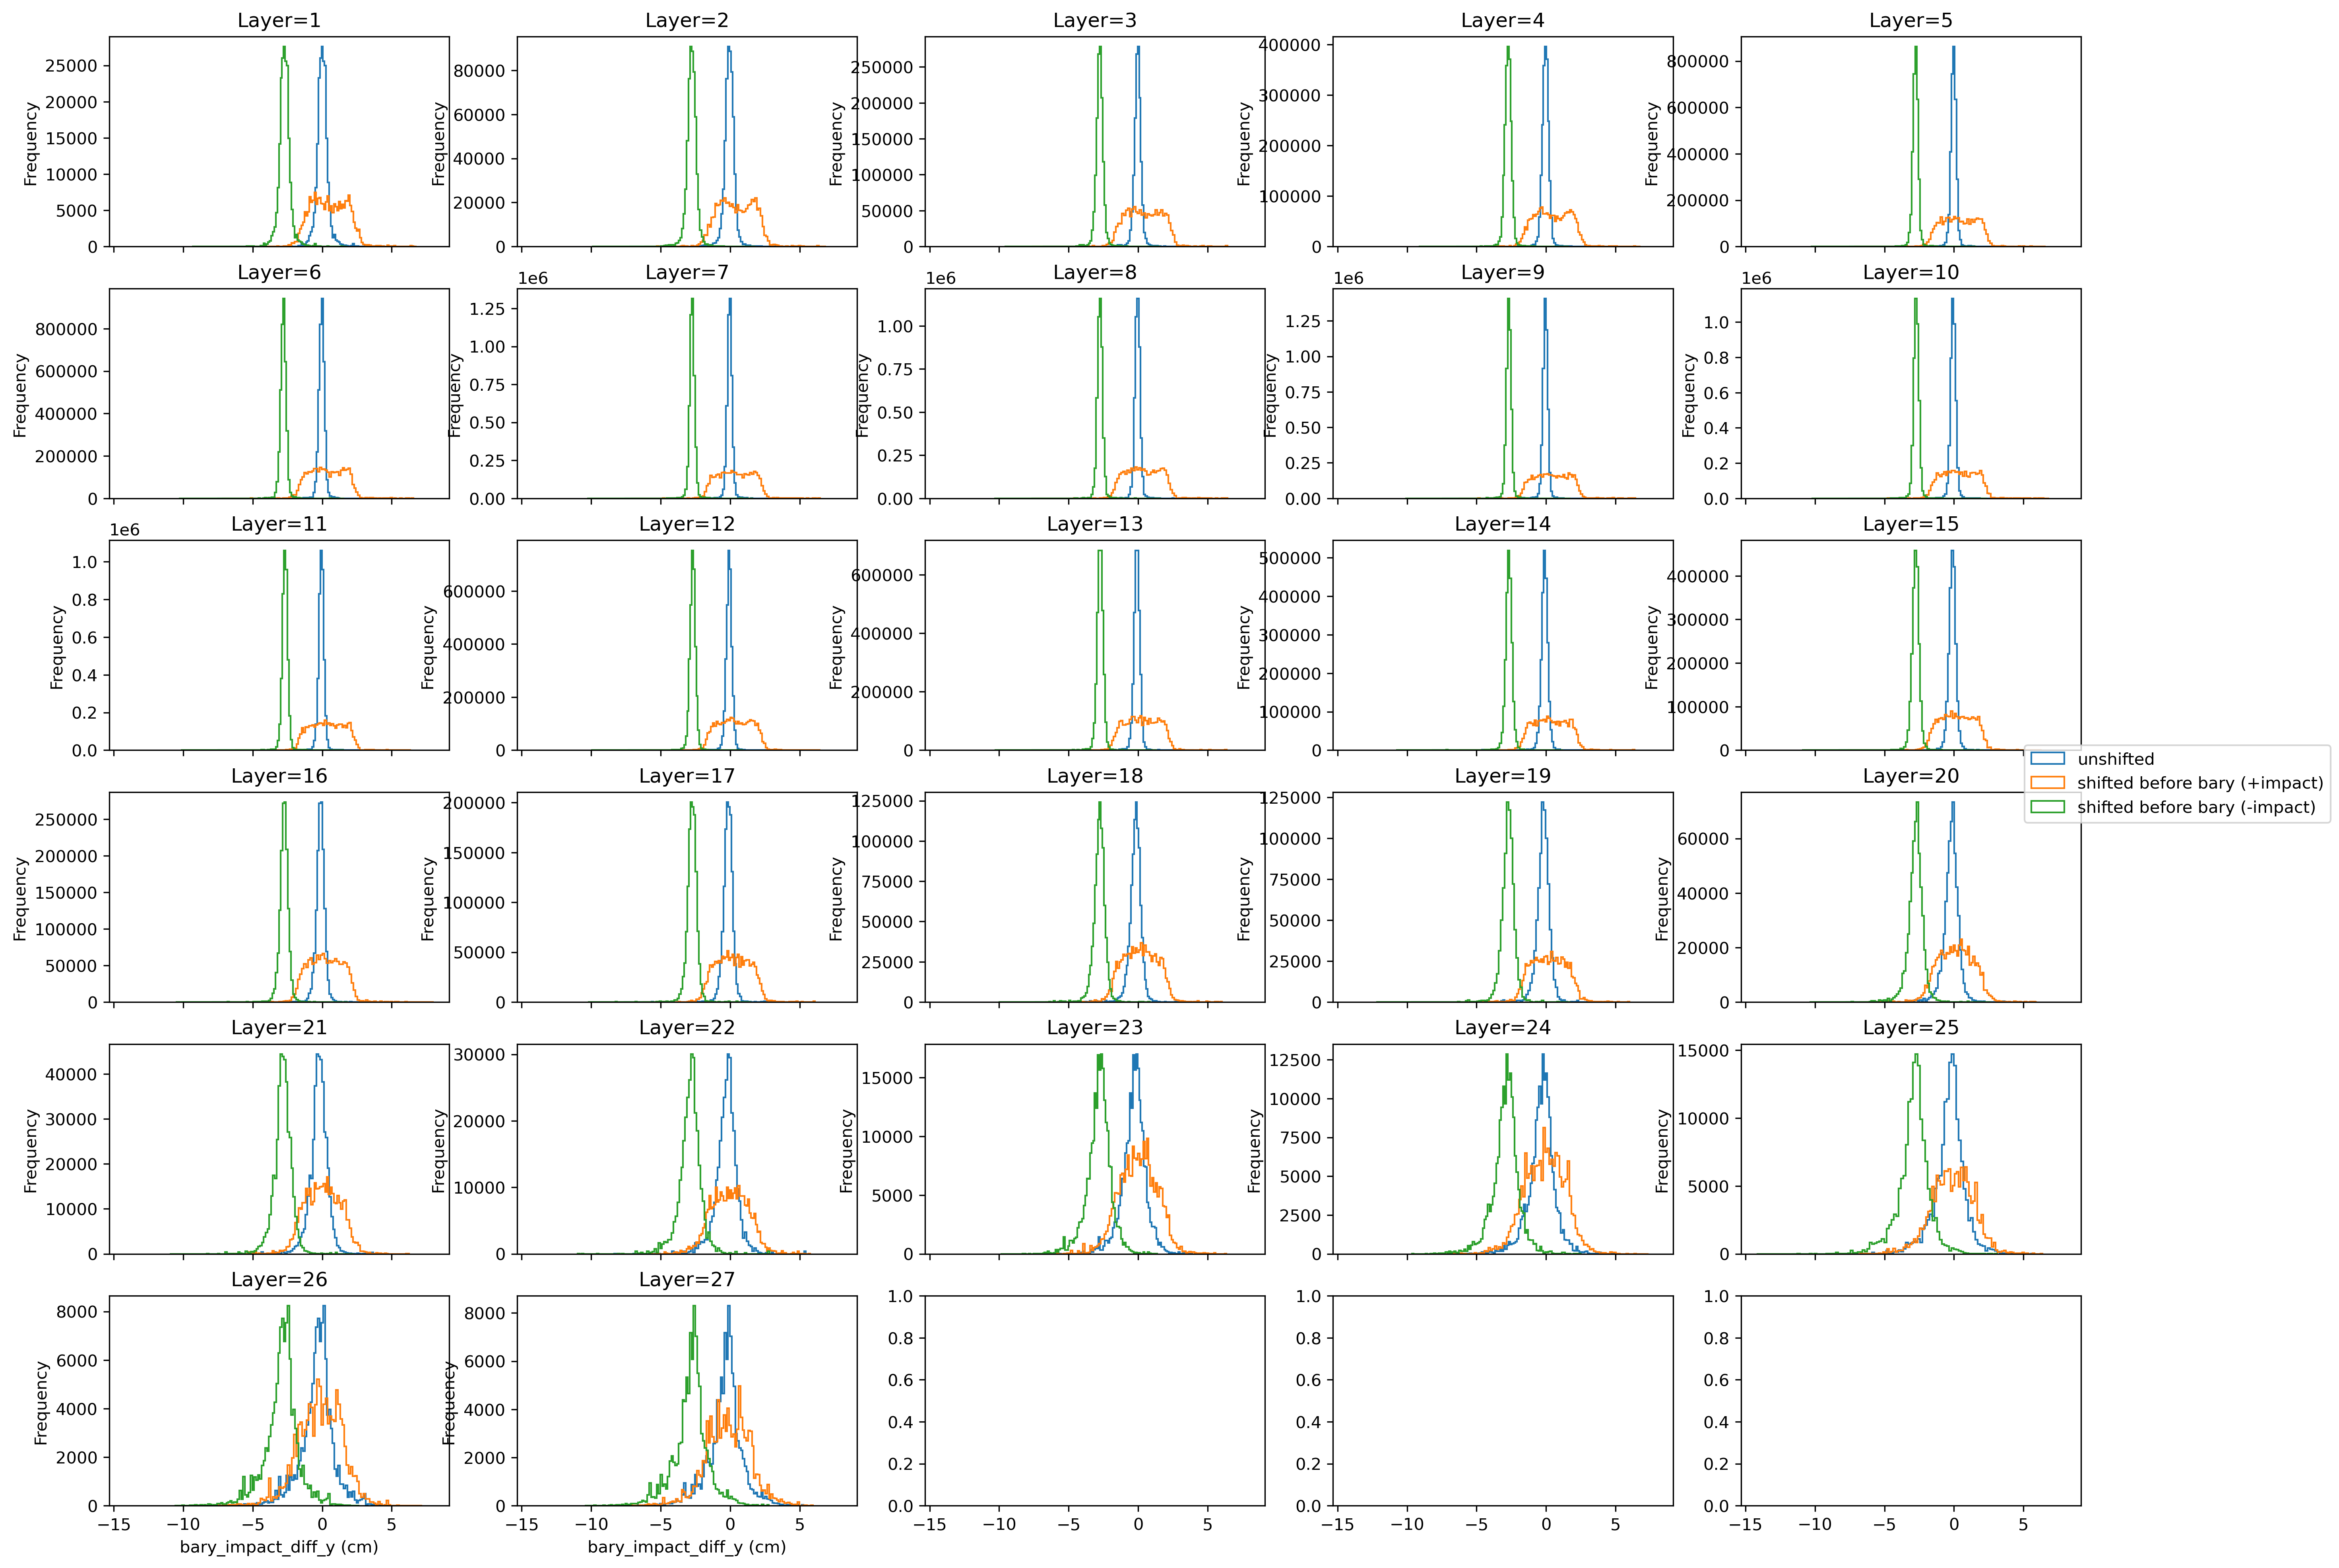

In [17]:
makePlots(plot_df, "bary_impact_diff_y")

In [19]:
barycenter_impact_df[["bary_impact_diff_x", "bary_impact_diff_y", 
    "bary_impact_diff_x_shiftedBefore_minus", "bary_impact_diff_y_shiftedBefore_minus",
    "bary_impact_diff_x_shiftedBefore_plus", "bary_impact_diff_y_shiftedBefore_plus"]].groupby("layer").mean()

,bary_impact_diff_x,bary_impact_diff_y,bary_impact_diff_x_shiftedBefore_minus,bary_impact_diff_y_shiftedBefore_minus,bary_impact_diff_x_shiftedBefore_plus,bary_impact_diff_y_shiftedBefore_plus
layer,,,,,,
1,0.077924,0.008894,3.600084,-2.715276,-0.310571,0.514529
2,0.079772,-0.057887,3.706192,-2.770417,-0.225244,0.450141
3,0.054991,-0.049194,3.757781,-2.784334,-0.216473,0.411713
4,0.062774,-0.047382,3.744554,-2.737512,-0.248928,0.448559
5,0.053171,-0.041913,3.592191,-2.777733,-0.443753,0.384846
6,0.070027,-0.048064,3.678977,-2.808164,-0.375562,0.344438
7,0.062514,-0.048223,3.839624,-2.750973,-0.261032,0.377543
8,0.083178,-0.054737,3.866268,-2.754867,-0.254164,0.362655
9,0.084000,-0.056751,3.830540,-2.685461,-0.334388,0.408189
